# Part 0: Download files

Here, we give users the opportunity to try running our network on some sample images. First, we download the the weights for our best model as well as some sample images we can use to run the demo.

In [ ]:
import os

os.chdir('/content')
!wget https://homes.cs.washington.edu/~xuangela/model_weight.pt
!wget https://homes.cs.washington.edu/~xuangela/test_images.h5

--2022-12-11 07:49:18--  https://homes.cs.washington.edu/~xuangela/model_weight.pt
Resolving homes.cs.washington.edu (homes.cs.washington.edu)... 128.208.3.226, 2607:4000:200:12::e2
Connecting to homes.cs.washington.edu (homes.cs.washington.edu)|128.208.3.226|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1517871 (1.4M)
Saving to: ‘model_weight.pt’

model_weight.pt     100%[===================>]   1.45M  3.80MB/s    in 0.4s    

2022-12-11 07:49:19 (3.80 MB/s) - ‘model_weight.pt’ saved [1517871/1517871]

--2022-12-11 07:49:19--  https://homes.cs.washington.edu/~xuangela/test_images.h5
Resolving homes.cs.washington.edu (homes.cs.washington.edu)... 128.208.3.226, 2607:4000:200:12::e2
Connecting to homes.cs.washington.edu (homes.cs.washington.edu)|128.208.3.226|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 953158238 (909M)
Saving to: ‘test_images.h5’

test_images.h5      100%[===================>] 909.00M  39.9MB/s    in 21s     

202

#Part 1: Load the model weight


In [ ]:
import torch
import torch.nn as nn
import multiprocessing
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Using device', device)
num_workers = multiprocessing.cpu_count()
print('num workers:', num_workers)

Using device cpu
num workers: 2


In [ ]:
class ConvNet(nn.Module):
  def __init__(self):
    super(ConvNet, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=2, padding=1, bias=False)
    self.conv2 = nn.Conv2d(64, 128, 3, stride=2, padding=1)
    self.conv3 = nn.Conv2d(128, 256, 3, stride=2, padding=1)
    self.maxpool = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(4096, 2)

    self.best_accuracy = -1
    
  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = self.maxpool(x)
    x = self.conv2(x)
    x = F.relu(x)
    x = self.maxpool(x)
    x = self.conv3(x)
    x = F.relu(x)
    x = self.maxpool(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    return x

  def loss(self, prediction, label, reduction='mean'):
    loss = nn.BCEWithLogitsLoss(reduction=reduction)
    loss_val = loss(prediction.squeeze(), label.squeeze())
    return loss_val

  def load_model(self, file_path):
    """Restores the weights from a saved file

    This does more than the simple Pytorch restore. It checks that the names
    of variables match, and if they don't doesn't throw a fit. It is similar
    to how Caffe acts. This is especially useful if you decide to change your
    network architecture but don't want to retrain from scratch.

    Args:
        net(torch.nn.Module): The net to restore
        file_path(str): The file path
    """

    net_state_dict = self.state_dict()
    restore_state_dict = torch.load(file_path)

    restored_var_names = set()

    print('Restoring:')
    for var_name in restore_state_dict.keys():
        if var_name in net_state_dict:
            var_size = net_state_dict[var_name].size()
            restore_size = restore_state_dict[var_name].size()
            if var_size != restore_size:
                print('Shape mismatch for var', var_name, 'expected', var_size, 'got', restore_size)
            else:
                if isinstance(net_state_dict[var_name], torch.nn.Parameter):
                    # backwards compatibility for serialized parameters
                    net_state_dict[var_name] = restore_state_dict[var_name].data
                try:
                    net_state_dict[var_name].copy_(restore_state_dict[var_name])
                    print(str(var_name) + ' -> \t' + str(var_size) + ' = ' + str(int(np.prod(var_size) * 4 / 10**6)) + 'MB')
                    restored_var_names.add(var_name)
                except Exception as ex:
                    print('While copying the parameter named {}, whose dimensions in the model are'
                          ' {} and whose dimensions in the checkpoint are {}, ...'.format(
                              var_name, var_size, restore_size))
                    raise ex

    ignored_var_names = sorted(list(set(restore_state_dict.keys()) - restored_var_names))
    unset_var_names = sorted(list(set(net_state_dict.keys()) - restored_var_names))
    print('')
    if len(ignored_var_names) == 0:
        print('Restored all variables')
    else:
        print('Did not restore:\n\t' + '\n\t'.join(ignored_var_names))
    if len(unset_var_names) == 0:
        print('No new variables')
    else:
        print('Initialized but did not modify:\n\t' + '\n\t'.join(unset_var_names))

    print('Restored %s' % file_path)

model = ConvNet().to(device)
model.load_model('/content/model_weight.pt')

Restoring:
conv1.weight -> 	torch.Size([64, 3, 3, 3]) = 0MB
conv2.weight -> 	torch.Size([128, 64, 3, 3]) = 0MB
conv2.bias -> 	torch.Size([128]) = 0MB
conv3.weight -> 	torch.Size([256, 128, 3, 3]) = 1MB
conv3.bias -> 	torch.Size([256]) = 0MB
fc1.weight -> 	torch.Size([2, 4096]) = 0MB
fc1.bias -> 	torch.Size([2]) = 0MB

Restored all variables
No new variables
Restored /content/model_weight.pt


# Part 2: load the dataset

In [ ]:
import torch
import tensorflow as tf
import h5py

# Data loader
class H5Dataset(torch.utils.data.Dataset):
    def __init__(self, h5_file, transform=None):
        self.transform = transform
        self.h5_file = h5py.File(h5_file, 'r')
        self.images = self.h5_file['images'][:]
        self.images = torch.tensor(self.images, dtype=torch.float)
        self.images = self.images.permute(0, 3, 1, 2)
        self.labels = self.h5_file['labels'][:]
        
    def __len__(self):
        return self.labels.shape[0]
      
    def __getitem__(self, idx):
        data = self.images[idx]
        label = self.labels[idx]
        if (self.labels[idx] == 0):
            label = torch.tensor([1, 0], dtype=torch.float)
        else:
            label = torch.tensor([0, 1], dtype=torch.float)

        if self.transform:
            data = self.transform(data)
        return (data, label)

data_test = H5Dataset('/content/test_images.h5')

In [ ]:
kwargs = {'num_workers': multiprocessing.cpu_count(),
            'pin_memory': True} if torch.cuda.is_available() else {}
            
test_loader = torch.utils.data.DataLoader(data_test, batch_size=1,
                                        shuffle=True, **kwargs)
print(len(test_loader))

606


# Part 3: Live Demo!

In [ ]:
import torch.nn.functional as F

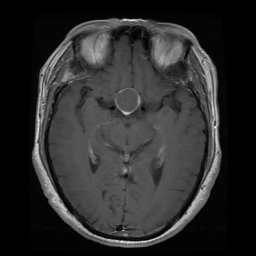

Our model found that there WAS A tumor
There WAS A tumor


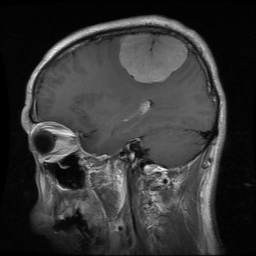

Our model found that there WAS A tumor
There WAS A tumor


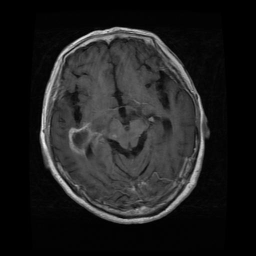

Our model found that there WAS A tumor
There WAS A tumor


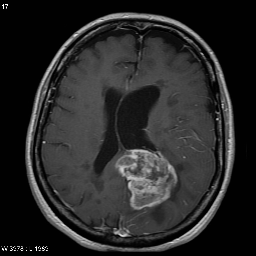

Our model found that there WAS A tumor
There WAS A tumor


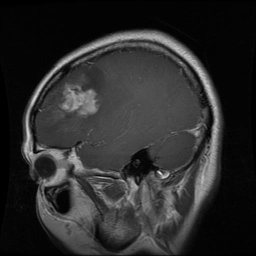

Our model found that there WAS A tumor
There WAS A tumor


In [ ]:
NUM_TO_TEST = 5
from PIL import Image

im_num = 0
with torch.no_grad():
    for batch_idx, (data, label) in enumerate(test_loader):
        if im_num >= NUM_TO_TEST:
            break
        im_num += 1
        data, label = data.to(device), label.to(device)
        output = model(data)
        pred = "NO" if output.max(1)[1] == 0 else "A"
        correct_labels = "NO" if  label.max(1)[1] == 0 else "A"

        images = np.array(data).astype("uint8")
        img = Image.fromarray(np.transpose(images[0], (1, 2, 0)), 'RGB')
        display(img)


        print("Our model found that there WAS " + pred + " tumor")
        print("There WAS " + correct_labels + " tumor")

